## Setup

## Create dataset from directory

In [8]:
import tensorflow as tf
from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


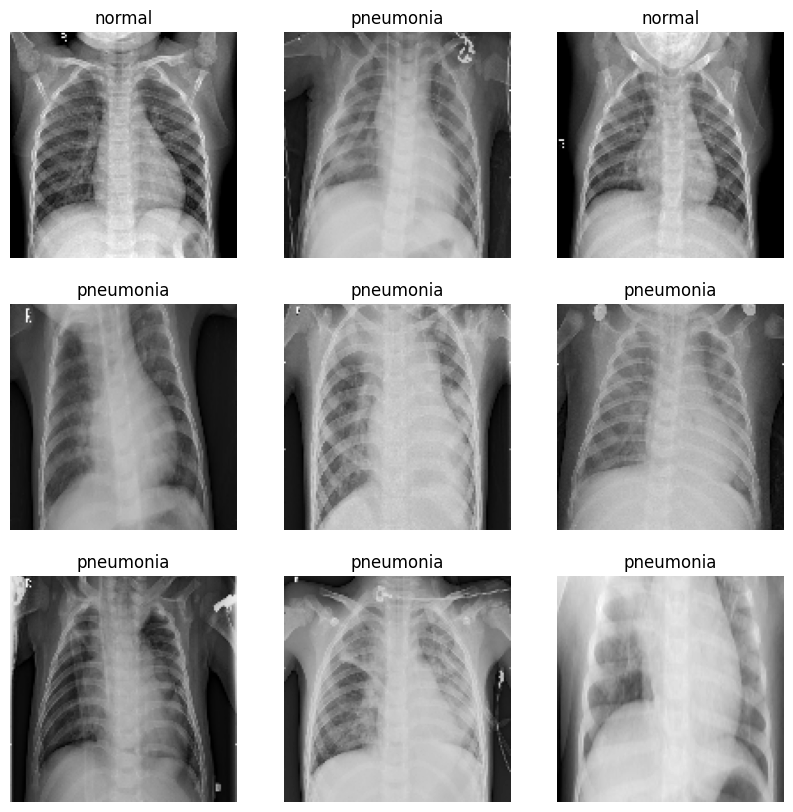

In [9]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [10]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

In [11]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Create CNN model

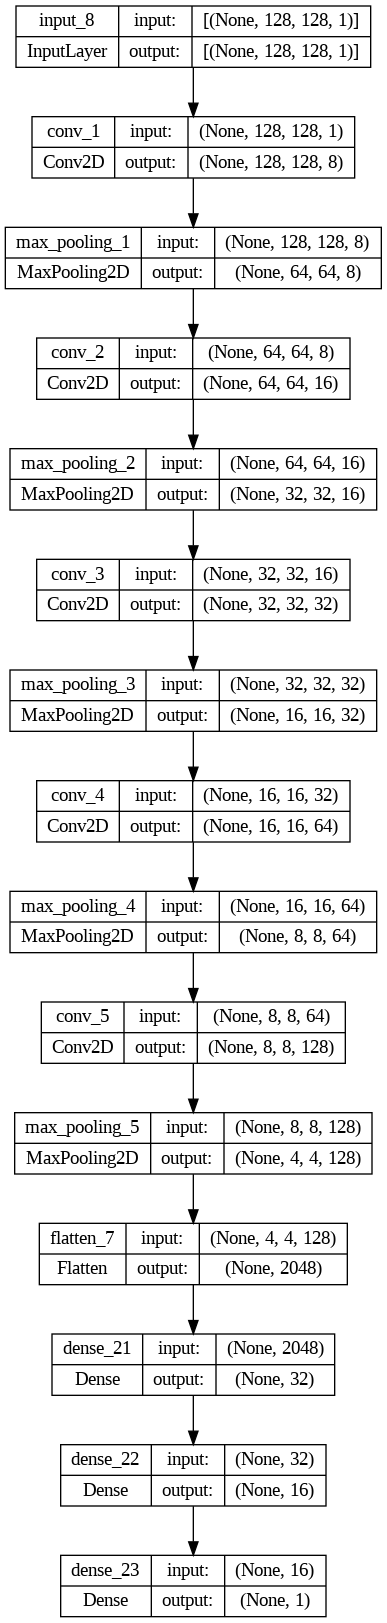

In [12]:
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses
)

# Define CNN model
input = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))

l1 = layers.Conv2D(8, (3, 3), padding='same', activation='relu', name='l1')(input)
l1_mp = layers.MaxPooling2D((2, 2), name='l1_mp')(l1)

l2 = layers.Conv2D(16, (3, 3), padding='same', activation='relu', name='l2')(l1_mp)
l2_mp = layers.MaxPooling2D((2, 2), name='l2_mp')(l2)

l3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='l3')(l2_mp)
l3_mp = layers.MaxPooling2D((2, 2), name='l3_mp')(l3)

l4 = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='l4')(l3_mp)
l4_mp = layers.MaxPooling2D((2, 2), name='l4_mp')(l4)

l5 = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='l5')(l4_mp)
l5_mp = layers.MaxPooling2D((2, 2), name='l5_mp')(l5)

flat = layers.Flatten(name='flat')(l5_mp)

l6 = layers.Dense(32, activation='relu', name='l6')(flat)

l7 = layers.Dense(16, activation='relu', name='l7')(l6)

cnn_output = layers.Dense(1, activation='sigmoid')(l7)
cnn = Model(inputs=input, outputs=cnn_output)

# Compile CNN model
cnn.compile(optimizer=optimizers.Adam(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])
cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1 (Conv2D)                     │ (None, 128, 128, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1_mp (MaxPooling2D)            │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2 (Conv2D)                     │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_mp (MaxPooling2D)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l3 (Conv2D)                     │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l3_mp (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l4 (Conv2D)                     │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l4_mp (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l5 (Conv2D)                     │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l5_mp (MaxPooling2D)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat (Flatten)                  │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l6 (Dense)                      │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l7 (Dense)                      │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,353 (642.00 KB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 0 (0.00 B)

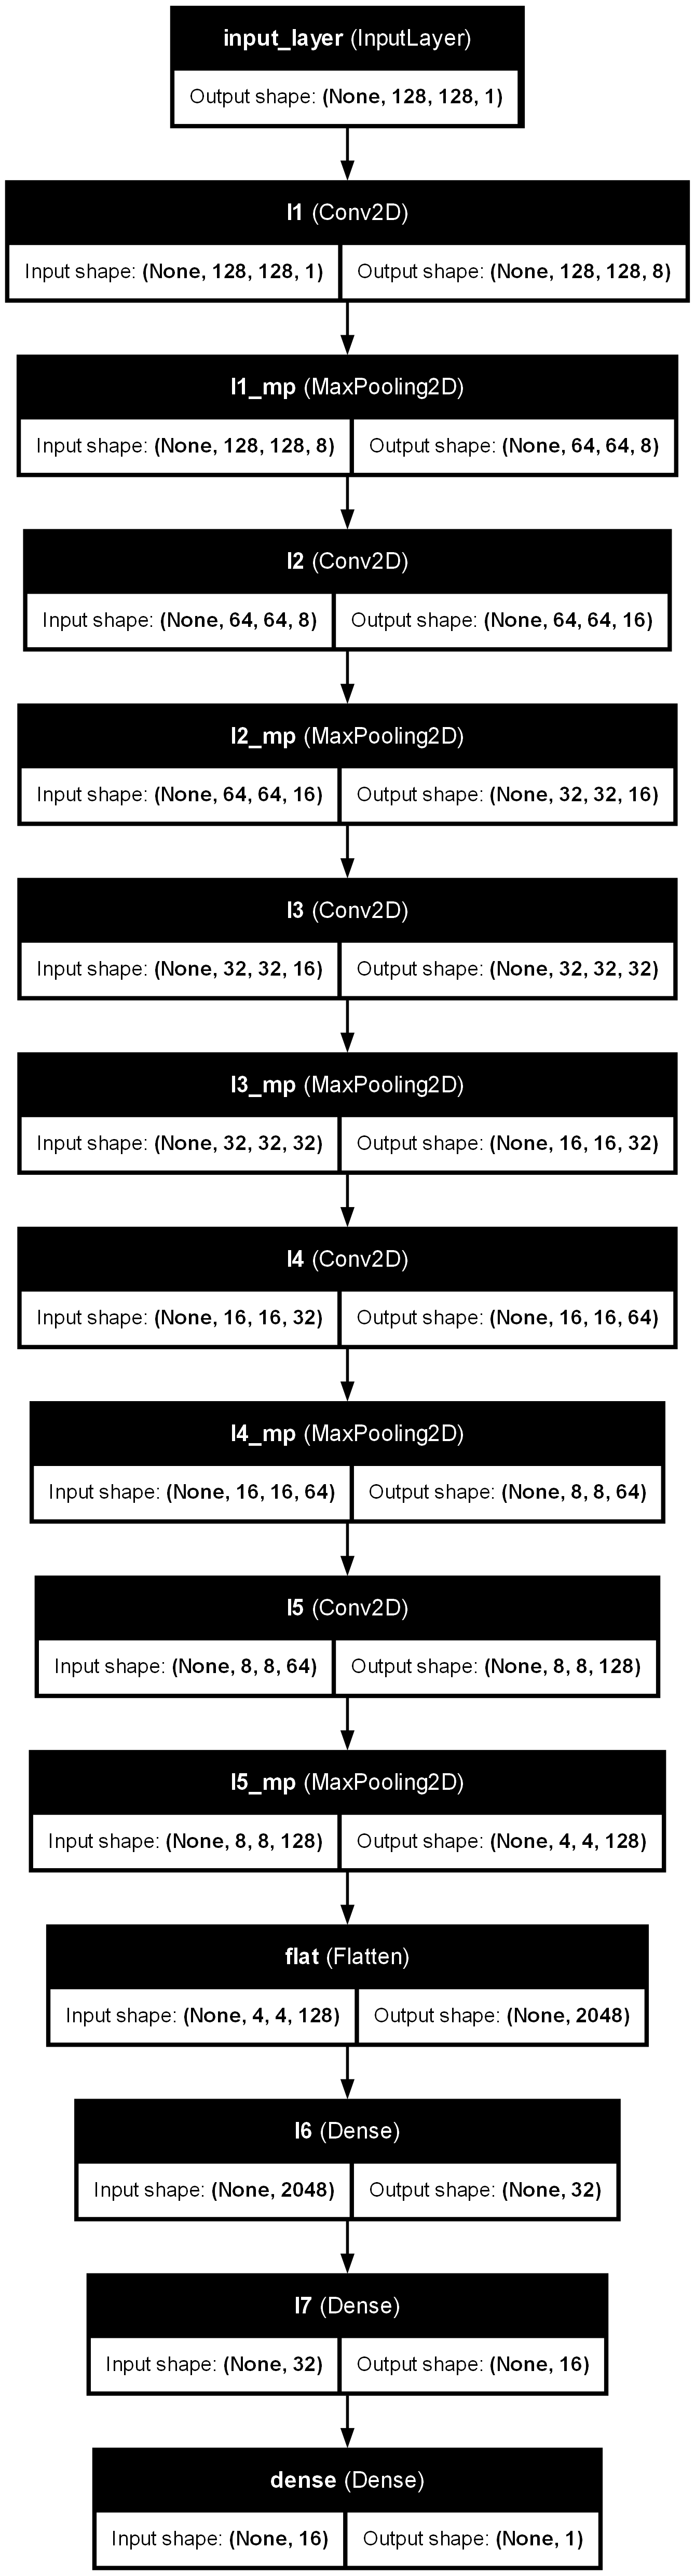

In [13]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(cnn, show_shapes=True, show_layer_names=True)

In [14]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights
)

Epoch 1/5


82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5959 - loss: 1.2115 - val_accuracy: 0.8125 - val_loss: 0.4216
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9308 - loss: 0.1593 - val_accuracy: 1.0000 - val_loss: 0.0905
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9632 - loss: 0.0954 - val_accuracy: 0.9375 - val_loss: 0.1168
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9572 - loss: 0.1113 - val_accuracy: 1.0000 - val_loss: 0.1458
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9785 - loss: 0.0567 - val_accuracy: 0.9375 - val_loss: 0.1567


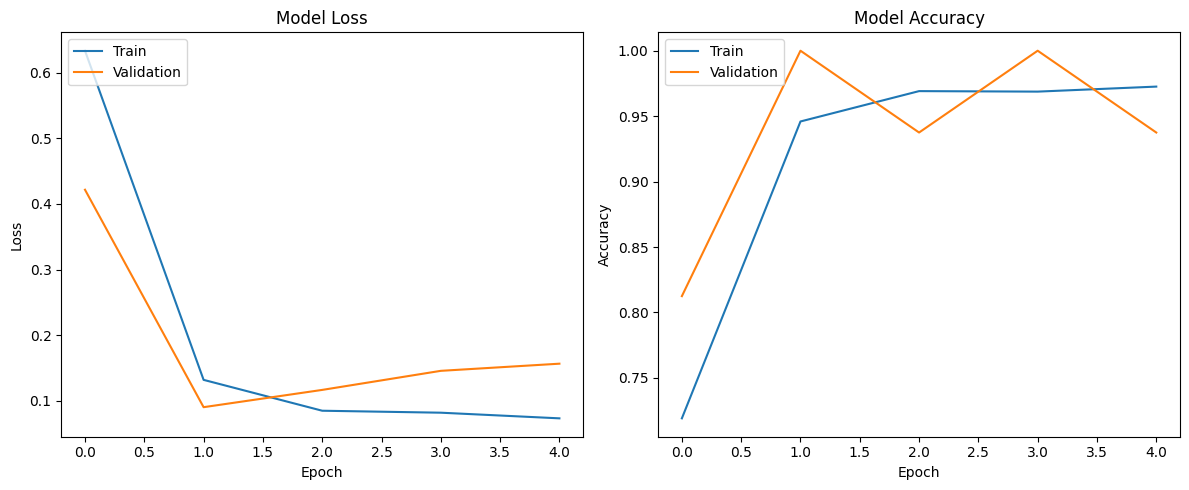

In [22]:
import matplotlib.pyplot as plt

# Set up the matplotlib figure with two subplots, side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns, figure size of 12x5 inches

# Plot training & validation loss values on the first subplot
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')
pl.grid()

# Plot training & validation accuracy values on the second subplot
ax2.plot(history.history['accuracy'], label='Train')
ax2.plot(history.history['val_accuracy'], label='Validation')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')
pl.grid()

# Show the plot
plt.tight_layout()  # Automatically adjust subplots to give specified padding
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


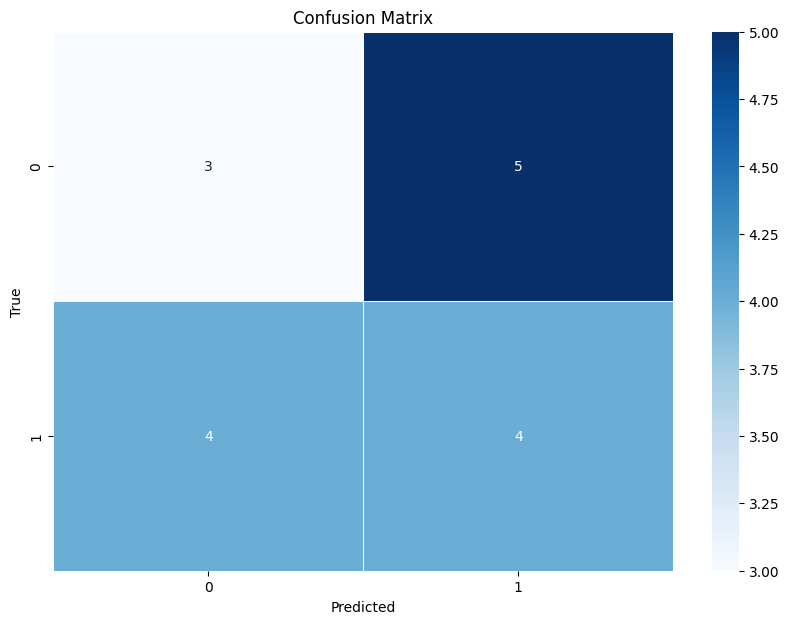

Validation Accuracy: 0.4375
Validation F1 Score: 0.47058823529411764


In [16]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the labels on the validation dataset
val_predictions = cnn.predict(val_ds)
val_predicted_classes = np.round(val_predictions).astype(int)

# Extract true labels from the validation dataset
val_true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Create a confusion matrix
cm = confusion_matrix(val_true_labels, val_predicted_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Validation metrics
val_accuracy = accuracy_score(val_true_labels, val_predicted_classes)
val_f1 = f1_score(val_true_labels, val_predicted_classes)

print("Validation Accuracy:", val_accuracy)
print("Validation F1 Score:", val_f1)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


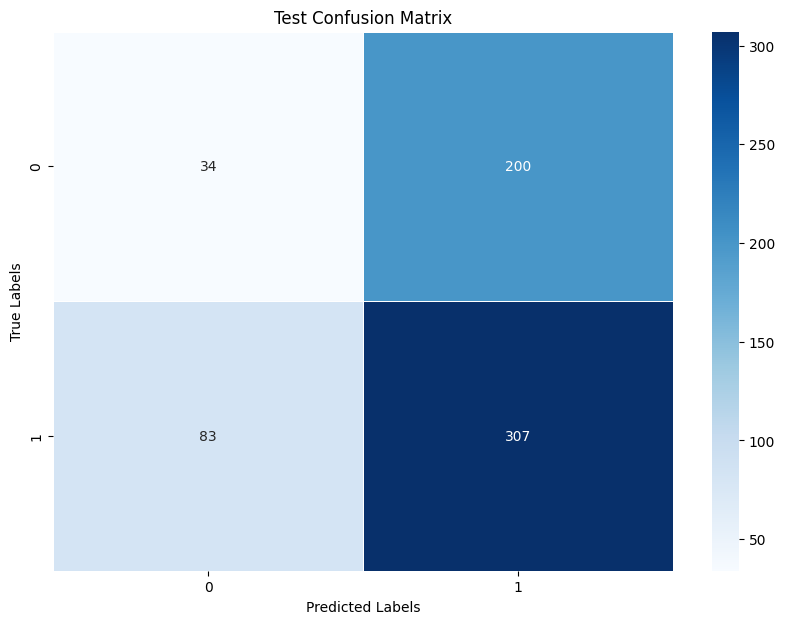

Test Accuracy: 0.5464743589743589
Test F1 Score: 0.6845039018952063


In [17]:
# Predict the labels on the test dataset
test_predictions = cnn.predict(test_ds)
test_predicted_classes = np.round(test_predictions).astype(int)

# Extract true labels from the test dataset
test_true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Create a confusion matrix
test_cm = confusion_matrix(test_true_labels, test_predicted_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix')
plt.show()


# Test metrics
test_accuracy = accuracy_score(test_true_labels, test_predicted_classes)
test_f1 = f1_score(test_true_labels, test_predicted_classes)

print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)

### Print the misclassified images

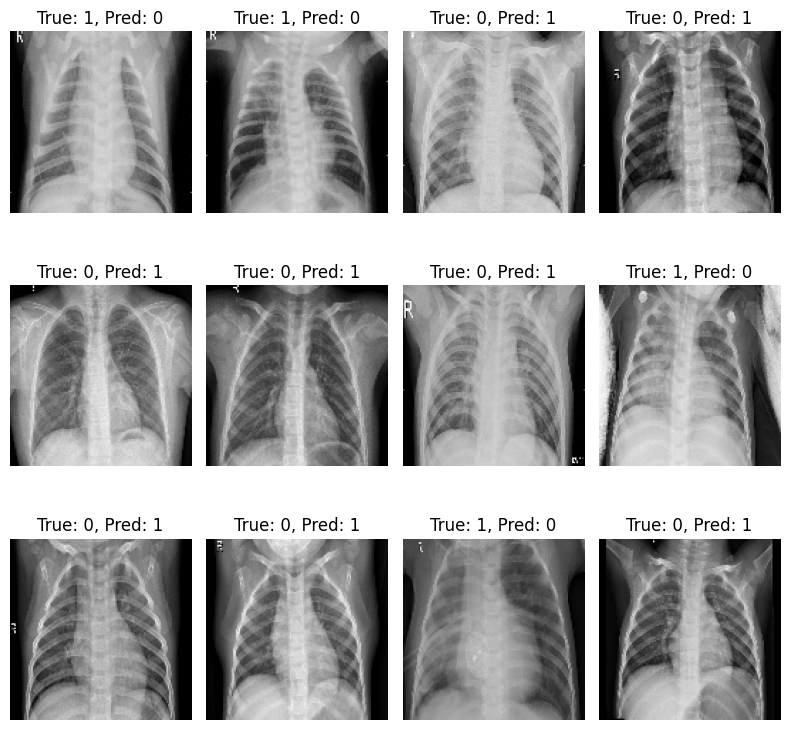

In [21]:
test_predicted_classes = np.round(test_predictions).astype(int).squeeze()

# Retrieve the images and labels from the test dataset
test_images = []
test_labels = []
for imgs, labels in test_ds:
    test_images.append(imgs.numpy())  # Convert tensor to numpy
    test_labels.append(labels.numpy())

# Convert list to a single numpy array
test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0).squeeze()  # Squeeze here to remove the extra dimension

# Identify misclassified images
misclassified_indices = np.where(test_labels != test_predicted_classes)[0]

# Plot misclassified images
plt.figure(figsize=(8, 8))
for i, index in enumerate(misclassified_indices[:12]):  # Display the first 9 misclassified images
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(test_images[index].squeeze(), cmap='gray')
    true_label = int(test_labels[index])  # No need for .item() if we squeeze the labels array outside the loop
    predicted_label = int(test_predicted_classes[index])
    plt.title(f'True: {true_label}, Pred: {predicted_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()